In [12]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from conv_emergence import NLGPLoader

In [2]:
L = 40 # 28
D = L #** 2

def Z(g):
    return np.sqrt( (2/np.pi) * np.arcsin( (g**2) / (1 + (g**2)) ) )

def generate_gaussian(L, xi, num_samples=1):
    dim = 1
    if isinstance(L, tuple):
        dim = len(L)
        if dim > 2:
            raise ValueError("L must be a tuple of length 1 or 2")
        if L[0] != L[1]:
            raise ValueError("L[0] must be equal to L[1]")
        L = L[0]
    C = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            C[i, j] = np.exp(- (i - j) ** 2 / (xi ** 2))
    
    if dim > 1:
        C = np.kron(C, C)
    
    z = np.random.multivariate_normal(np.zeros(L ** dim), C, size=num_samples)
    if dim > 1:
        z = z.reshape((num_samples, L, L))
        
    return z

def gain_function(x):
    return erf(x)

def generate_non_gaussian(L, xi, g, num_samples=1):
    z = generate_gaussian(L, xi, num_samples)
    x = gain_function(g * z) / Z(g)
    return x
    

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
    
    def get_param_count(self) -> int:
        """Count the number of params"""
        return sum((np.prod(p.size()) for p in self.parameters()))

    def get_trainable_param_count(self) -> int:
        """Count the number of trainable params"""
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        return sum((np.prod(p.size()) for p in model_parameters))

    def freeze_weights(self) -> None:
        """Freeze the model"""
        for param in self.parameters():
            param.requires_grad = False
            
class NeuralNet(Model):
    def __init__(self, input_dim, hidden_dim, activation=nn.Sigmoid()):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation = activation
        
        self.ff1 = nn.Linear(input_dim, hidden_dim, bias=True)
        # self.ff1.weight.data.normal_(0, 1/np.sqrt(input_dim)) # mean 0, variance 1/D
        # self.ff1.bias.data.zero_()
        # self.v_k = 1/hidden_dim
        # self.hidden1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.ff2 = nn.Linear(hidden_dim, 1, bias=True)
        
    def forward(self, x):
        # print(x.shape)
        x = self.activation(self.ff1(x))# / np.sqrt(self.input_dim))
        # out = self.v_k * x.sum(dim=1)
        # x = self.activation(self.hidden1(x))
        # print(x.shape)
        out = self.ff2(x)
        return out.squeeze(1)
    
class ConvNet(Model):
    def __init__(self, input_dim, hidden_dim, activation=nn.Sigmoid()):
        super().__init__()
        
        self.input_dim = input_dim
        self.num_hidden = hidden_dim
        self.activation = activation
        
        # self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=4, stride=4, padding=0)
        conv_out_size = self._get_conv_output((1, L, L))
        self.ff1 = nn.Linear(conv_out_size, hidden_dim)
        self.ff2 = nn.Linear(hidden_dim, 1)
        # self.ff1 = nn.Linear(conv_out_size, 1)
        
    def _get_conv_output(self, shape):
        bs = 1
        input = torch.autograd.Variable(torch.rand(bs, *shape))
        # output_feat = self.mp(self.conv1(input))
        output_feat = self.conv1(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size
        
    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        x = x.reshape(batch_size, 1, L, L)
        x = self.conv1(x)
        # x = self.mp(x)
        x = self.activation(x)
        x = x.reshape(batch_size, -1)
        
        x = self.activation(self.ff1(x))# / np.sqrt(self.input_dim)))
        x = self.ff2(x)
        # x = self.ff1(x)
        return x.squeeze(1)
    
class NLGP_Precompute(Dataset):
    def __init__(self, L, xi1, xi2, g, num_samples=1):
        self.D = L[0] * L[1] if isinstance(L, tuple) else L
        self.xi1 = xi1
        self.xi2 = xi2
        self.g = g
        self.num_samples = num_samples
        
        self.X1 = generate_non_gaussian(L, self.xi1, self.g, self.num_samples // 2).reshape(-1, self.D)
        self.X2 = generate_non_gaussian(L, self.xi2, self.g, self.num_samples - self.num_samples // 2).reshape(-1, self.D)
        self.X = np.concatenate((self.X1, self.X2))
        self.y = np.concatenate((np.ones(self.num_samples // 2), -np.ones(self.num_samples - self.num_samples // 2)))
        # self.y = np.concatenate((np.ones(self.num_samples), np.zeros(self.num_samples)))
        
        idx = np.random.permutation(self.num_samples)
        self.X = torch.from_numpy(self.X[idx]).float()
        self.y = torch.from_numpy(self.y[idx]).float()
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class NLGP_Online(Dataset):
    def __init__(self, L, xi1, xi2, g, batch_size=1, num_epochs=1):
        self.D = L[0] * L[1] if isinstance(L, tuple) else L
        self.xi1 = xi1
        self.xi2 = xi2
        self.g = g
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
    def __len__(self):
        return self.num_epochs
    
    def __getitem__(self, idx):
        if np.random.randint(2) == 0:
            X = generate_non_gaussian(L, self.xi1, self.g, self.batch_size).reshape(-1, self.D)
            y = 1
        else:    
            X = generate_non_gaussian(L, self.xi2, self.g, self.batch_size).reshape(-1, self.D)
            y = -1
        
        X = torch.from_numpy(X).float()
        y = torch.tensor(self.batch_size * [y]).float()#.reshape(-1, 1)
        return X, y

In [5]:
K = 100
model = NeuralNet(input_dim=D, hidden_dim=K, activation=nn.Tanh())
# model.load_state_dict(torch.load('model_L40_K100_500k.pt'))
# model = ConvNet(input_dim=D, hidden_dim=K, activation=nn.Tanh())
# model.load_state_dict(torch.load('model_L100_K301_900k.pt'))
opt = torch.optim.SGD(model.parameters(), lr=1e-2)# * K)
num_epochs = 5000
every_epoch = 500

batch_size = 100 # 4 # 16 # 1
# data = NLGP_Precompute(L, xi1=np.sqrt(20), xi2=np.sqrt(10), g=3, num_samples=(batch_size * num_epochs))
# # data = NLGP_Online(L, xi1=np.sqrt(20), xi2=np.sqrt(10), g=3, batch_size=batch_size, num_epochs=num_epochs)
# # loader = DataLoader(data, batch_size=batch_size, shuffle=False)
# # loader = DataLoader(data, batch_size=1, shuffle=False)
# loader = DataLoader(data, batch_size=batch_size, shuffle=False)

loader = NLGPLoader(L, xi1=np.sqrt(20), xi2=np.sqrt(10), g=3, batch_size=batch_size, num_epochs=num_epochs)

losses = np.zeros(num_epochs)
accs = np.zeros(num_epochs)
iprs = []
for epoch, (X, y) in enumerate(loader):
    # print(X.shape, y.shape)
    # X = X.squeeze(0)
    # y = y.squeeze(0)
    yhat = model(X)
    loss = F.mse_loss(yhat, y)
    # loss = F.binary_cross_entropy_with_logits(yhat, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses[epoch] = loss.item()
    accs[epoch] = ((yhat > 0) == (y > 0)).to(torch.float32).mean()
    
    if epoch % every_epoch == 0 or epoch == num_epochs - 1:
        weights = model.ff1.weight.detach().numpy()
        ipr_ = np.power(weights, 4).sum(axis=1) / np.power(np.power(weights, 2).sum(axis=1), 2)
        iprs.append(ipr_)
        print(f'Epoch {epoch}: loss={losses[max(epoch-every_epoch,0):epoch+1].mean():.4f}, acc={accs[max(epoch-every_epoch,0):epoch+1].mean():.4f} IPR>0.05={100 * np.mean(ipr_ > 0.05):.2f}%')

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_17544/345673390.py:27: UserWarning: Using a target size (torch.Size([1, 100])) that is different to the input size (torch.Size([1, 100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(yhat, y)


Epoch 0: loss=1.0484, acc=0.5090 IPR>0.05=17.00%
Epoch 500: loss=1.0045, acc=0.5004 IPR>0.05=16.00%
Epoch 1000: loss=1.0013, acc=0.5011 IPR>0.05=16.00%
Epoch 1500: loss=1.0011, acc=0.4999 IPR>0.05=16.00%
Epoch 2000: loss=1.0009, acc=0.4999 IPR>0.05=16.00%
Epoch 2500: loss=1.0008, acc=0.4997 IPR>0.05=16.00%
Epoch 3000: loss=1.0008, acc=0.4994 IPR>0.05=16.00%
Epoch 3500: loss=1.0006, acc=0.5006 IPR>0.05=16.00%
Epoch 4000: loss=1.0006, acc=0.4987 IPR>0.05=16.00%
Epoch 4500: loss=1.0006, acc=0.4998 IPR>0.05=16.00%
Epoch 4999: loss=1.0006, acc=0.4985 IPR>0.05=16.00%


In [95]:
# torch.save(model.state_dict(), f'model_L{L}_K{K}_500k.pt')

### Viz

In [6]:
L = 40
K = 100
model = NeuralNet(input_dim=L, hidden_dim=K, activation=nn.Tanh())
model.load_state_dict(torch.load(f'model_L{L}_K{K}_500k.pt'))

<All keys matched successfully>

[0.10343985 0.0440274  0.05047081 0.04668112 0.03845542 0.05476099
 0.04903983 0.0927207  0.09989233 0.05494366 0.06187275 0.04189341
 0.05356693 0.08082535 0.04718441 0.04401478 0.0475878  0.05935336
 0.04582143 0.05902411 0.05504399 0.12623206 0.06328283 0.05149848
 0.0414428  0.05510523 0.16684447 0.07349238 0.05269508 0.04869796
 0.05927994 0.07634046 0.11682676 0.08456498 0.14564556 0.0533462
 0.06535777 0.04860941 0.12480929 0.04388041 0.05660897 0.04756365
 0.05459052 0.05468215 0.05323112 0.06987941 0.11114962 0.06453869
 0.05744915 0.0764926  0.05037055 0.05161585 0.05008768 0.05448303
 0.05209443 0.1497868  0.07252643 0.05928759 0.0498545  0.1148411
 0.04741023 0.04877299 0.07314557 0.04843319 0.05250458 0.1410177
 0.19669938 0.05047383 0.05586137 0.05006448 0.06503858 0.07020773
 0.16321667 0.06646757 0.05063839 0.04910247 0.0543269  0.04536693
 0.06261461 0.0584328  0.05498647 0.2363011  0.05555763 0.07514583
 0.11365861 0.04454922 0.13275814 0.2475095  0.07559732 0.0488305

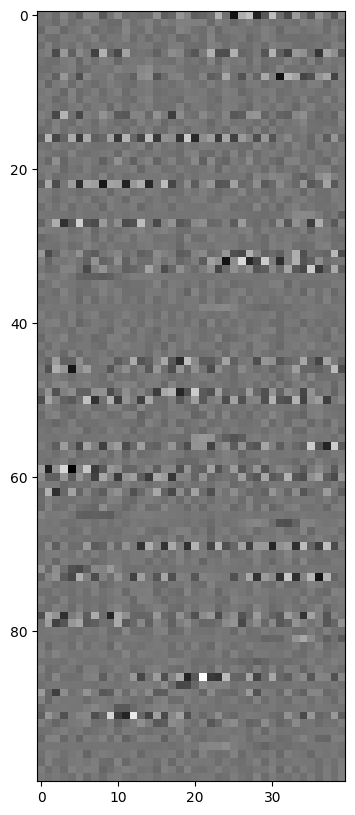

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
weights = model.ff1.weight.detach().numpy()
ax.imshow(weights, cmap='gray')

(array([58., 19.,  4.,  6.,  4.,  4.,  2.,  1.,  0.,  2.]),
 array([0.03845542, 0.05936082, 0.08026623, 0.10117164, 0.12207705,
        0.14298245, 0.16388786, 0.18479326, 0.20569868, 0.22660409,
        0.24750949]),
 <BarContainer object of 10 artists>)

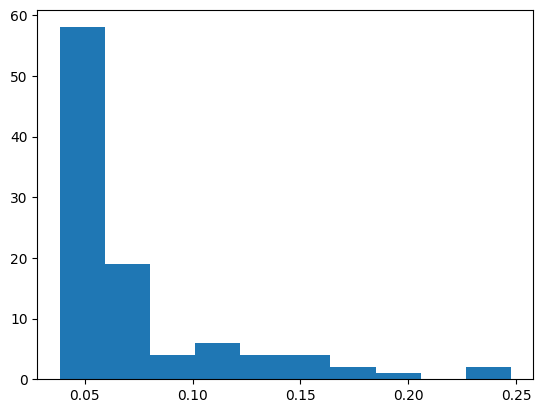

In [13]:
ipr = np.power(weights, 4).sum(axis=1) / np.power(np.power(weights, 2).sum(axis=1), 2)
plt.hist(ipr)

In [14]:
ipr

array([0.10343985, 0.0440274 , 0.05047081, 0.04668112, 0.03845542,
       0.05476099, 0.04903983, 0.0927207 , 0.09989233, 0.05494366,
       0.06187275, 0.04189341, 0.05356693, 0.08082535, 0.04718441,
       0.04401478, 0.0475878 , 0.05935336, 0.04582143, 0.05902411,
       0.05504399, 0.12623206, 0.06328283, 0.05149848, 0.0414428 ,
       0.05510523, 0.16684447, 0.07349238, 0.05269508, 0.04869796,
       0.05927994, 0.07634046, 0.11682676, 0.08456498, 0.14564556,
       0.0533462 , 0.06535777, 0.04860941, 0.12480929, 0.04388041,
       0.05660897, 0.04756365, 0.05459052, 0.05468215, 0.05323112,
       0.06987941, 0.11114962, 0.06453869, 0.05744915, 0.0764926 ,
       0.05037055, 0.05161585, 0.05008768, 0.05448303, 0.05209443,
       0.1497868 , 0.07252643, 0.05928759, 0.0498545 , 0.1148411 ,
       0.04741023, 0.04877299, 0.07314557, 0.04843319, 0.05250458,
       0.1410177 , 0.19669938, 0.05047383, 0.05586137, 0.05006448,
       0.06503858, 0.07020773, 0.16321667, 0.06646757, 0.05063

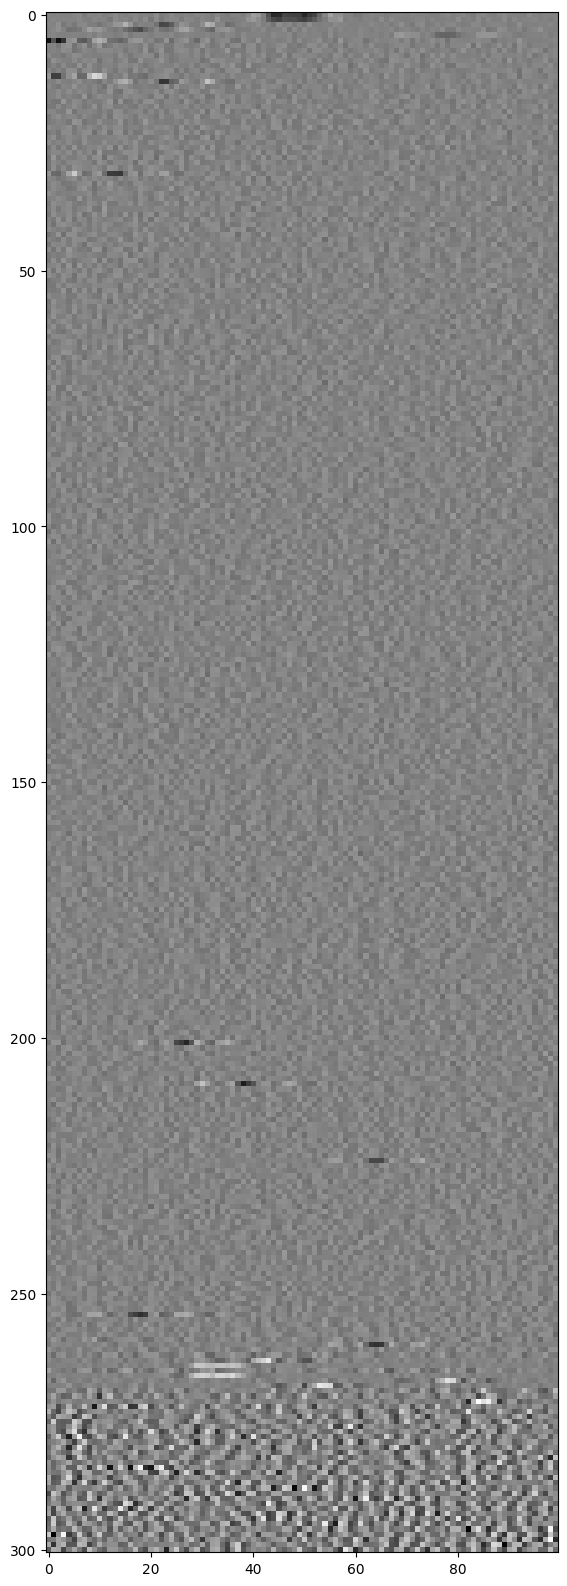

In [57]:
weights = model.ff1.weight.detach().numpy()
centers = np.mean(np.maximum(weights, 0) * np.arange(1, weights.shape[1] + 1), axis=1)
argsort = np.argsort(centers)
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(weights[argsort], cmap='gray')

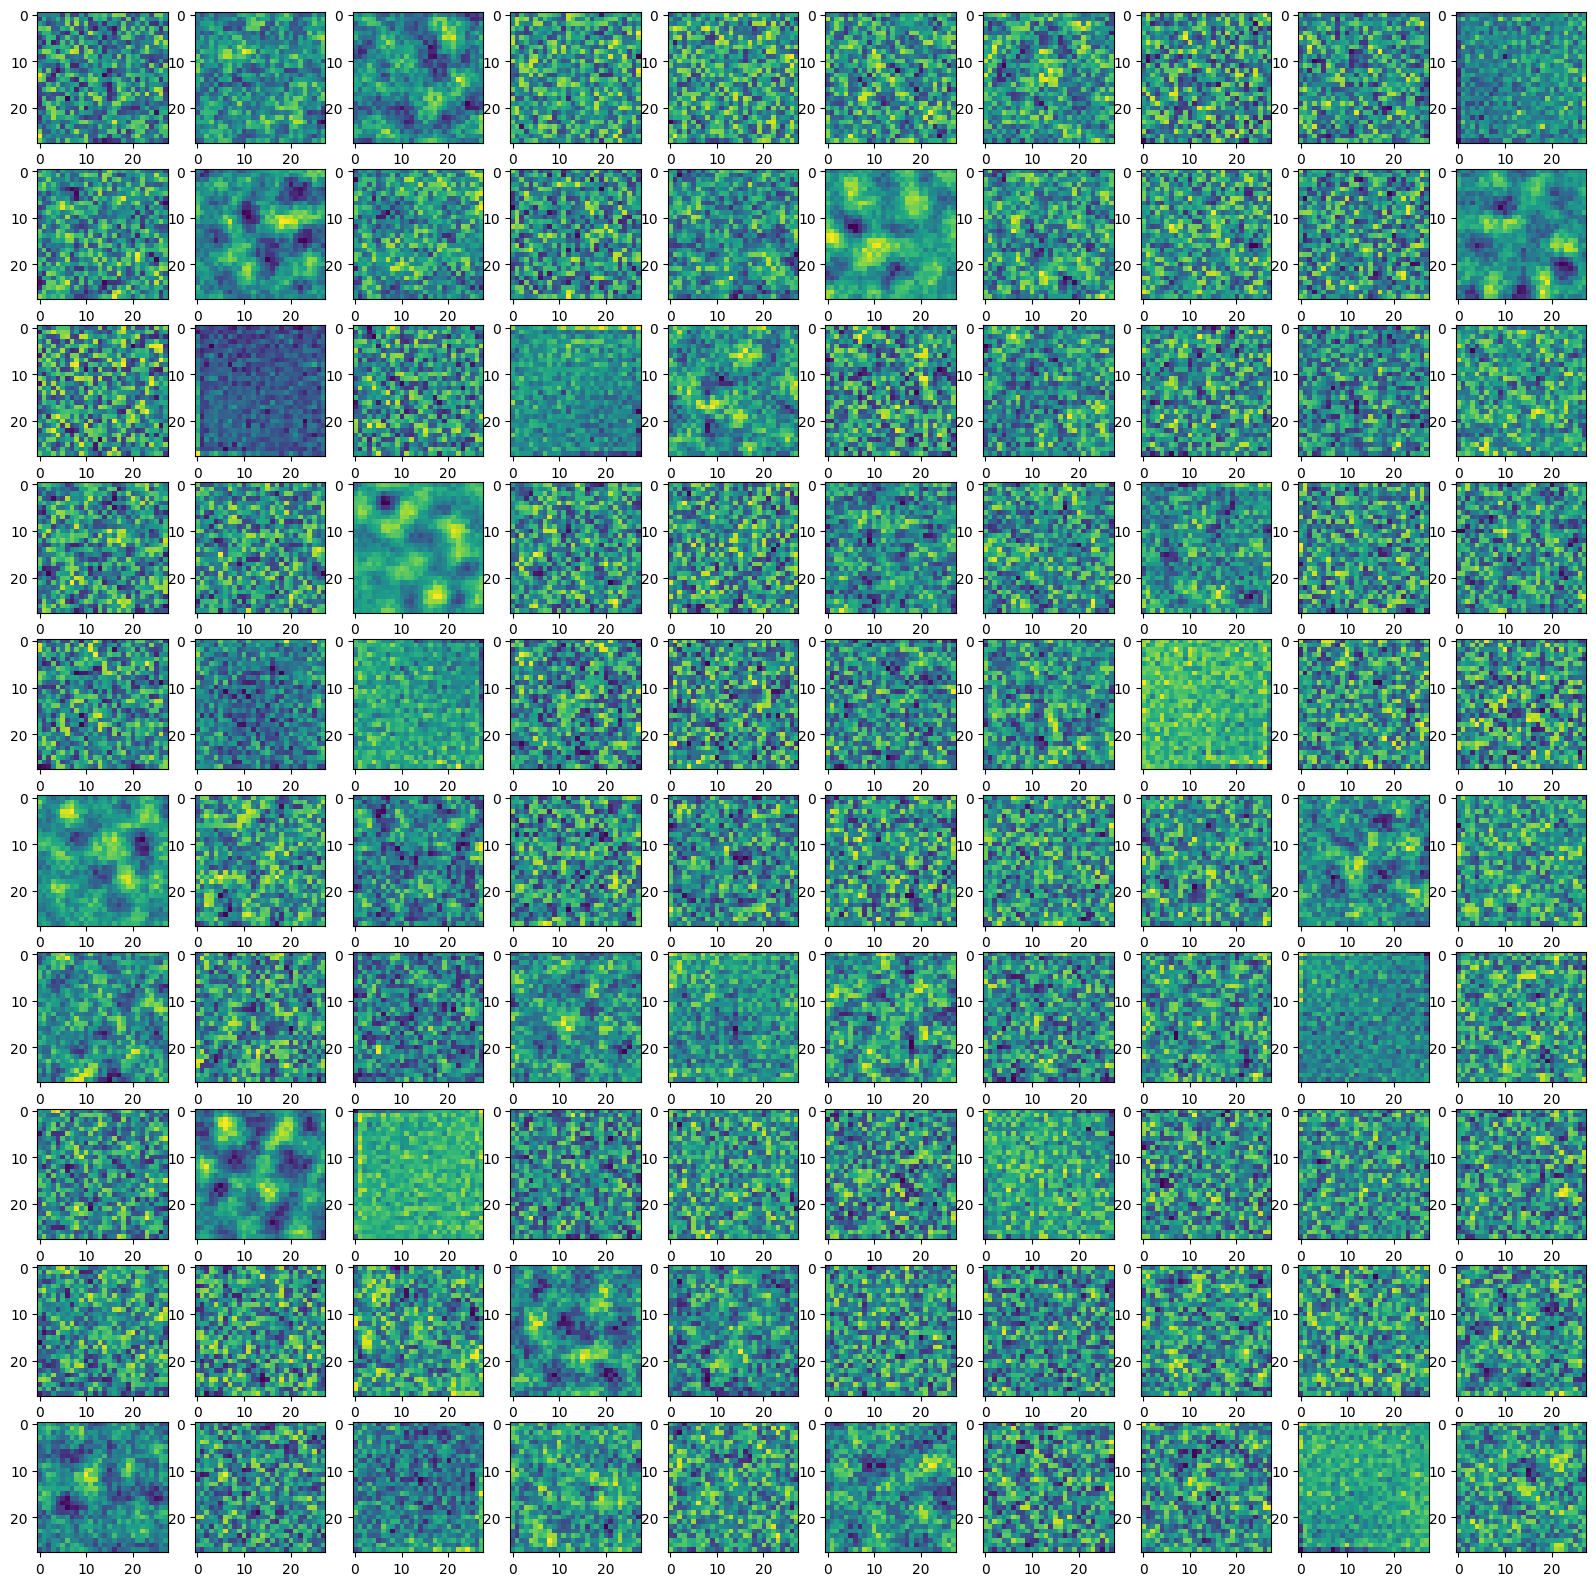

In [362]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(model.ff1.weight[i].reshape(L, L).detach().numpy())

tensor([-1.])


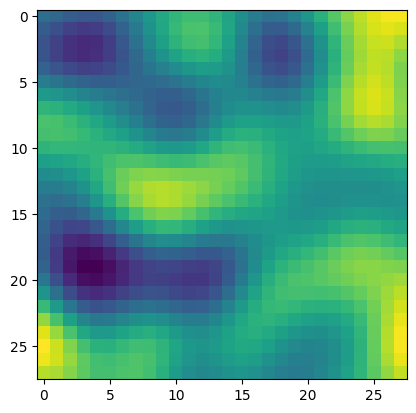

In [270]:
print(y)
_ = plt.imshow(X.reshape(L, L))

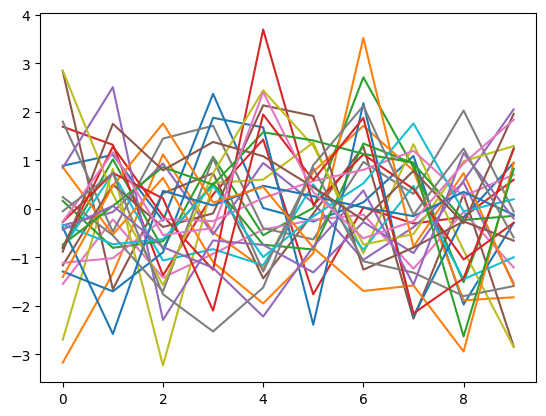

In [204]:
x = generate_non_gaussian(L, xi=0.1, g=0.1, num_samples=10)
_ = plt.plot(x)

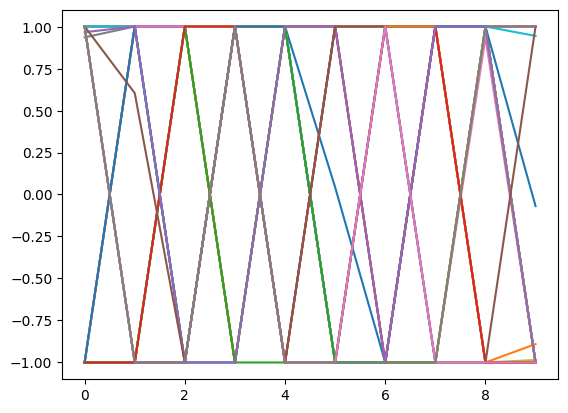

In [205]:
x = generate_non_gaussian(L, xi=0.1, g=100, num_samples=10)
_ = plt.plot(x)

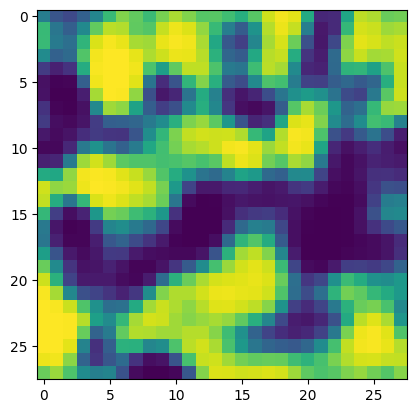

In [209]:
x = generate_non_gaussian((L, L), xi=0.1 * L, g=1, num_samples=10)
x = x.reshape(x.shape[0], L, L)
_ = plt.imshow(x[0])

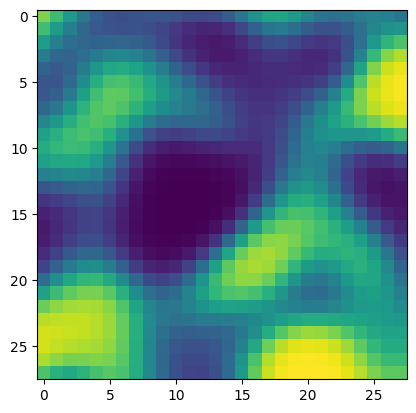

In [207]:
x = generate_non_gaussian((L, L), xi=0.2 * L, g=1, num_samples=10)
x = x.reshape(x.shape[0], L, L)
_ = plt.imshow(x[0])